In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
dataset = torchvision.datasets.CIFAR10(root= 'data', train=True, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [4]:
train_len = 35000
val_len = 10000
test_len = 5000
total_len = train_len + val_len + test_len

In [5]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])

In [6]:
print(f"Training set length: {len(train_set)}")
print(f"Validation set length: {len(val_set)}")
print(f"Test set length: {len(test_set)}")

Training set length: 35000
Validation set length: 10000
Test set length: 5000


In [7]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [8]:
class Softmax(torch.nn.Module):
    def __init__(self):
        super(Softmax, self).__init__()
        self.linear = torch.nn.Linear(3 * 32 * 32, 10)
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.linear(x)
        return x

In [9]:
model = Softmax().to(device)
loss_fun = torch.nn.CrossEntropyLoss()

In [10]:
weight_decays = [0, 0.1, 0.001 , 0.0001]
best_weight_decay = 0
best_val_accuracy = 0

for wd in weight_decays:
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=wd)
    
    epochs = 20
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fun(outputs, labels)
            loss.backward()
            optimizer.step()
            
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_weight_decay = wd

    print(f"Weight decay: {wd}, Validation Accuracy: {val_accuracy:.2f}%")

print(f"Best weight decay: {best_weight_decay}, Best Validation Accuracy: {best_val_accuracy:.2f}%")

Weight decay: 0, Validation Accuracy: 39.06%
Weight decay: 0.1, Validation Accuracy: 36.11%
Weight decay: 0.001, Validation Accuracy: 38.78%
Weight decay: 0.0001, Validation Accuracy: 40.34%
Best weight decay: 0.0001, Best Validation Accuracy: 40.42%


In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=best_weight_decay)

In [12]:
epochs = 200
loss_list = []
acc = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.view(-1, 3 * 32 * 32))
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    loss_list.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.view(-1, 3 * 32 * 32))
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    acc.append(accuracy)
    if epoch % 10 == 0:
        print("Epoch: {}. Loss: {}. Accuracy: {}".format(epoch, avg_loss, accuracy))

Epoch [1/200], Loss: 1.6779
Epoch: 0. Loss: 1.6778529113127938. Accuracy: 39.76
Epoch [2/200], Loss: 1.6762
Epoch [3/200], Loss: 1.6765
Epoch [4/200], Loss: 1.6756
Epoch [5/200], Loss: 1.6743
Epoch [6/200], Loss: 1.6722
Epoch [7/200], Loss: 1.6720
Epoch [8/200], Loss: 1.6701
Epoch [9/200], Loss: 1.6704
Epoch [10/200], Loss: 1.6676
Epoch [11/200], Loss: 1.6673
Epoch: 10. Loss: 1.6672670139473142. Accuracy: 39.75
Epoch [12/200], Loss: 1.6672
Epoch [13/200], Loss: 1.6661
Epoch [14/200], Loss: 1.6652
Epoch [15/200], Loss: 1.6645
Epoch [16/200], Loss: 1.6632
Epoch [17/200], Loss: 1.6635
Epoch [18/200], Loss: 1.6614
Epoch [19/200], Loss: 1.6602
Epoch [20/200], Loss: 1.6613
Epoch [21/200], Loss: 1.6587
Epoch: 20. Loss: 1.6587010561003328. Accuracy: 40.63
Epoch [22/200], Loss: 1.6587
Epoch [23/200], Loss: 1.6589
Epoch [24/200], Loss: 1.6577
Epoch [25/200], Loss: 1.6553
Epoch [26/200], Loss: 1.6544
Epoch [27/200], Loss: 1.6544
Epoch [28/200], Loss: 1.6549
Epoch [29/200], Loss: 1.6537
Epoch [30/

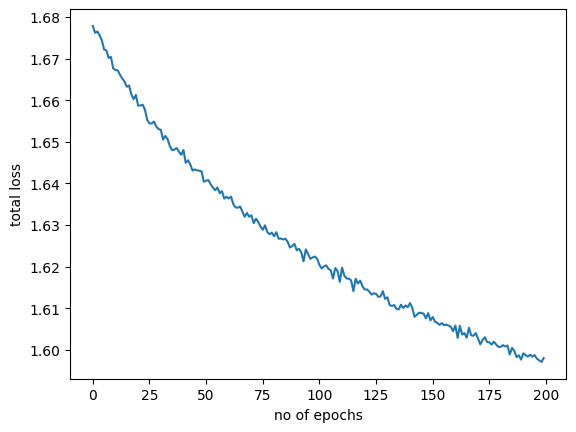

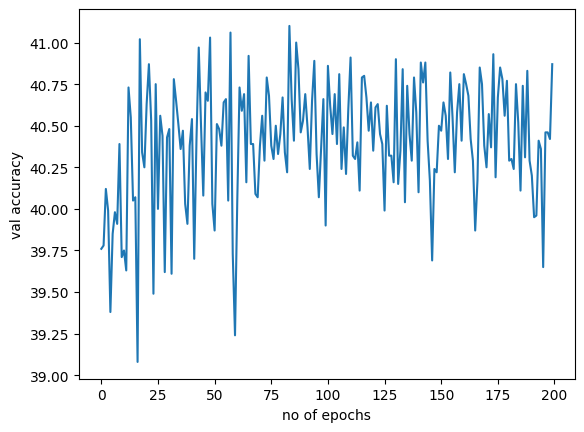

In [13]:
plt.plot(loss_list)
plt.xlabel("no of epochs")
plt.ylabel("total loss")
plt.show()

plt.plot(acc)
plt.xlabel("no of epochs")
plt.ylabel("val accuracy")
plt.show()

In [14]:
def evaluate_model(model, test_loader, device, num_classes):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(predicted.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.2f}%")

    class_names = [f"Class {i}" for i in range(len(classes))]
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

    return accuracy, report


accuracy, report = evaluate_model(model, test_loader, device, len(classes))

Test Accuracy: 0.40%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.46      0.47      0.47       499
     Class 1       0.46      0.49      0.47       519
     Class 2       0.30      0.22      0.26       478
     Class 3       0.28      0.22      0.25       508
     Class 4       0.33      0.31      0.32       496
     Class 5       0.29      0.41      0.34       469
     Class 6       0.46      0.43      0.44       510
     Class 7       0.48      0.48      0.48       506
     Class 8       0.48      0.57      0.52       487
     Class 9       0.47      0.44      0.45       528

    accuracy                           0.40      5000
   macro avg       0.40      0.40      0.40      5000
weighted avg       0.40      0.40      0.40      5000

